# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this : https://github.com/numenta/NAB
3. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

4. This is the very beginning of the process. Still need to do a lot of works!


# What's new in version 2
1. Add HTM unsupervised mode <br>
2. Add scoring mechanism using NAB https://github.com/numenta/NAB <br>
3. Can run over all dataset: go through the whole folder

In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from hmmlearn import hmm


In [2]:
# plot path:
plot_path = "plots/"

#data path
root_path = "Data/realKnownCause/realKnownCause/"
os.listdir(root_path)



['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

In [125]:
# Optional: run on all datasets:
path_all = [] 
directory = "Data/"
                                                                                                         
subdirs = [x[0] for x in os.walk(directory)]
for subdir in subdirs: 
    #print(subdir)
    for file in os.listdir(subdir):
        filename = os.fsdecode(file)
        if filename.endswith("csv"): 
            path_all.append(os.path.join(subdir,filename))
            continue
        else:
            continue



In [126]:
path_all[2]


'Data/artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
df = pd.read_csv(root_path+'ambient_temperature_system_failure.csv')

In [5]:
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
# convert time stamp to numerical data
df['timestamp'] = pd.to_datetime(df['timestamp'])

W0703 19:54:47.550448 140427740727104 legend.py:1247] No handles with labels found to put in legend.
W0703 19:54:47.735260 140427740727104 font_manager.py:1269] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0703 19:54:47.823500 140427740727104 font_manager.py:1269] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


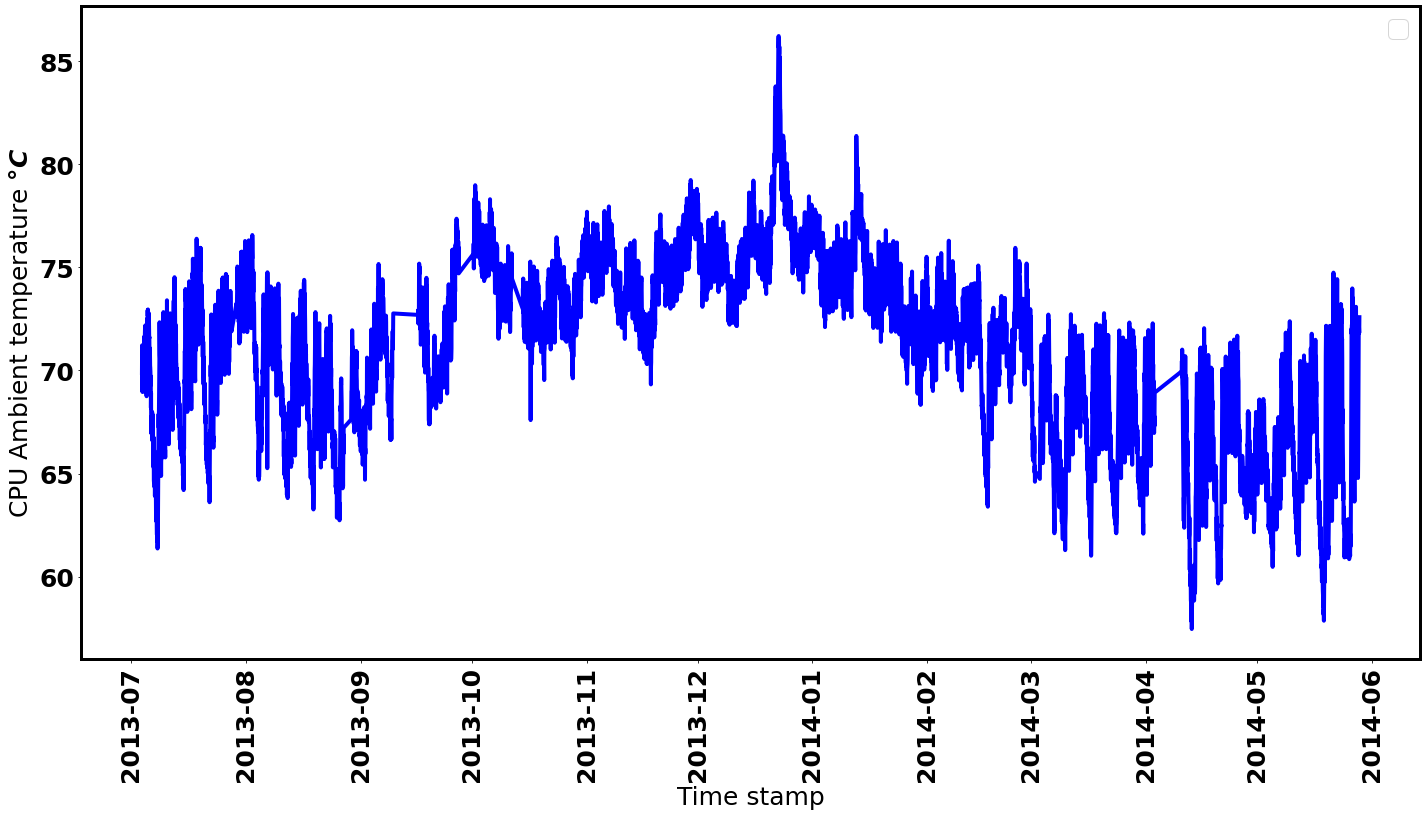

In [7]:
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


# plot the data using Celcius
#df.plot(x='timestamp', y='value')

plt.plot(df['timestamp'],df['value'],"b",linewidth=4,markersize=5)
#plt.plot(df['timestamp'],df['value'],"b",linewidth=4,markersize=5)

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()
save_path = plot_path + "Original" + ".png"

fig.savefig(save_path, dpi=300)


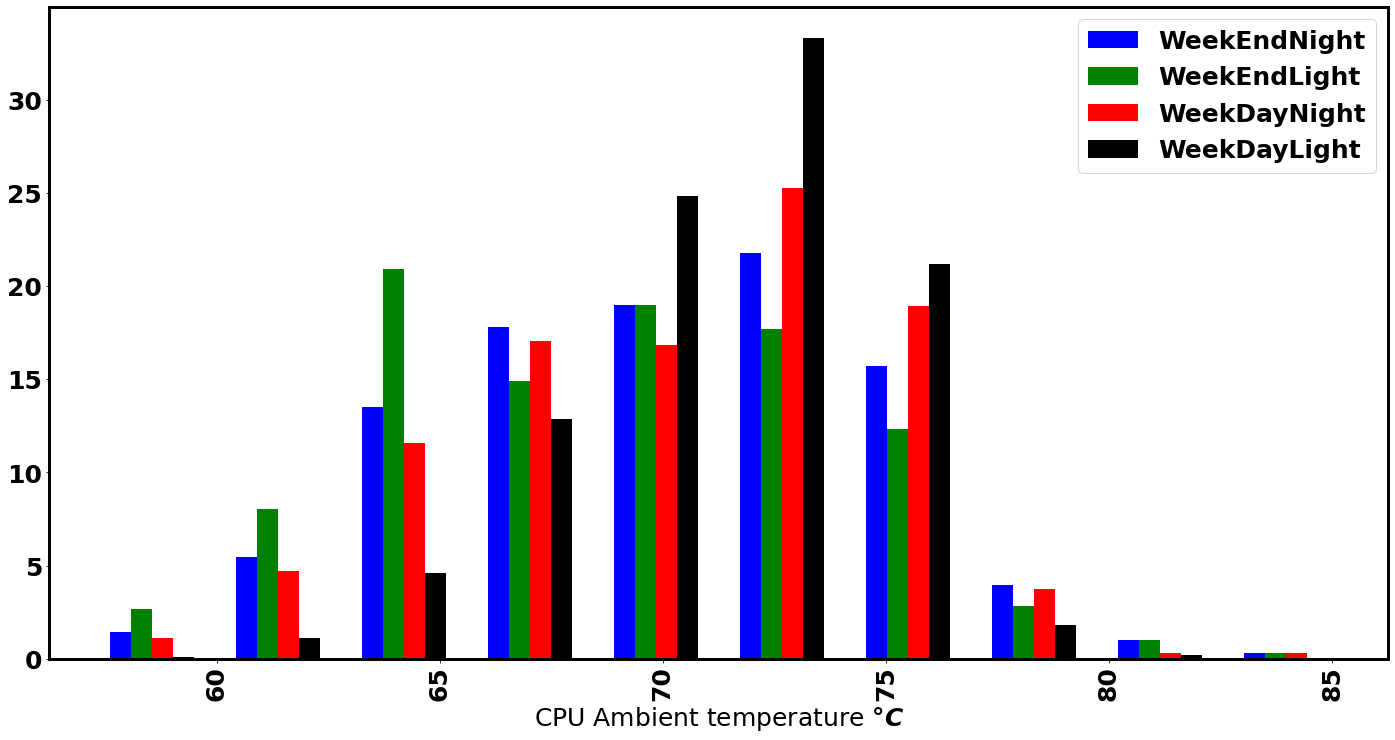

In [8]:
# Let's consider the correlation between weekday/hour/season vs failure
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)


# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')




plt.xlabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()


save_path = plot_path + "Original_featured" + ".png"

fig.savefig(save_path, dpi=300)


# K mean clustering method.

W0703 19:55:00.437209 140427740727104 legend.py:1247] No handles with labels found to put in legend.


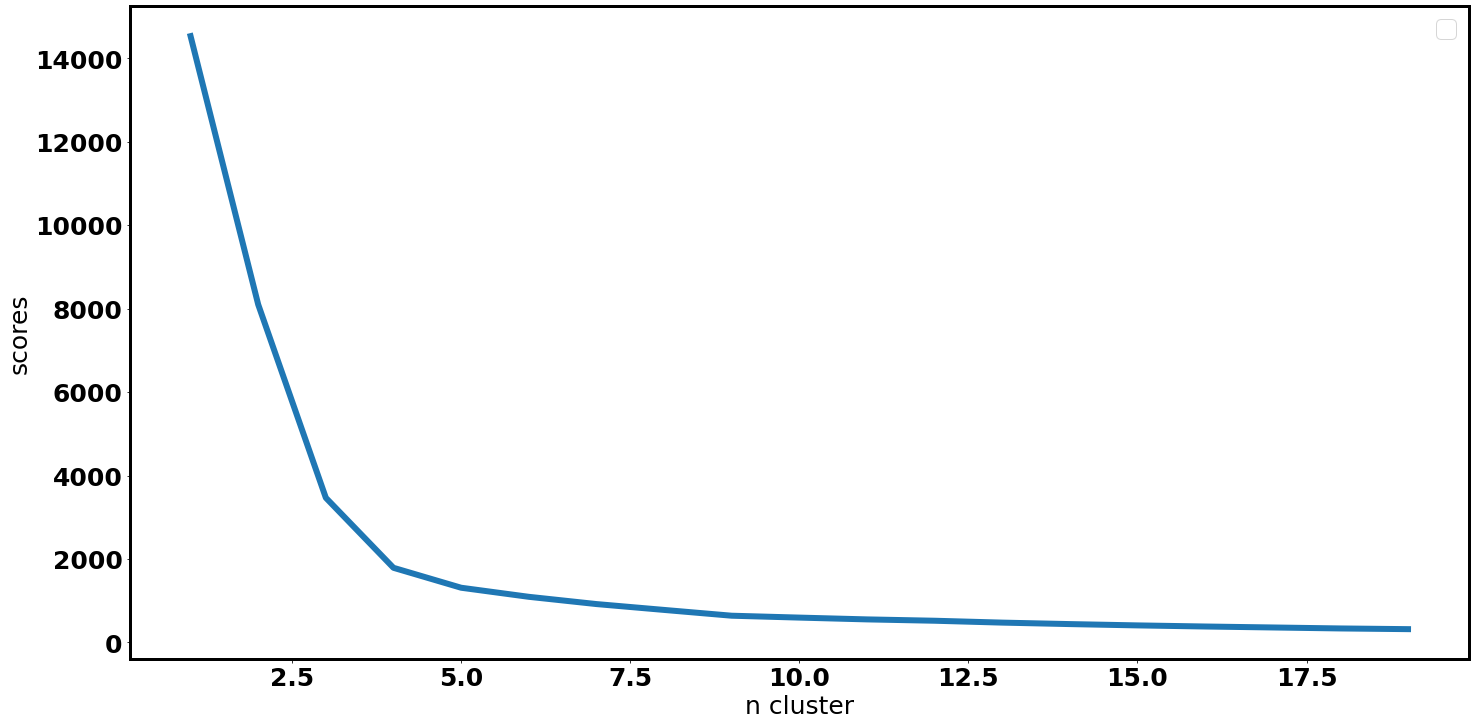

In [9]:

## Some hyper-parameters for K mean clustering:

n_clusters = 15
anomaly_ratio = 1




font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
scores = np.array(scores)
ax.plot(n_cluster, abs(scores),linewidth=6)



plt.xlabel("n cluster")
plt.ylabel(r"scores")

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

plt.show()



In [10]:
# Let's take a look at the previous plot: Choose around 10-15 clusters:
# predict each clustering


df['cluster'] = kmeans[n_clusters-1].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

1     716
3     664
8     613
13    610
12    590
7     586
6     582
9     532
10    432
14    358
0     350
11    346
4     343
2     307
5     238
Name: cluster, dtype: int64

W0703 19:55:00.796830 140427740727104 legend.py:1247] No handles with labels found to put in legend.


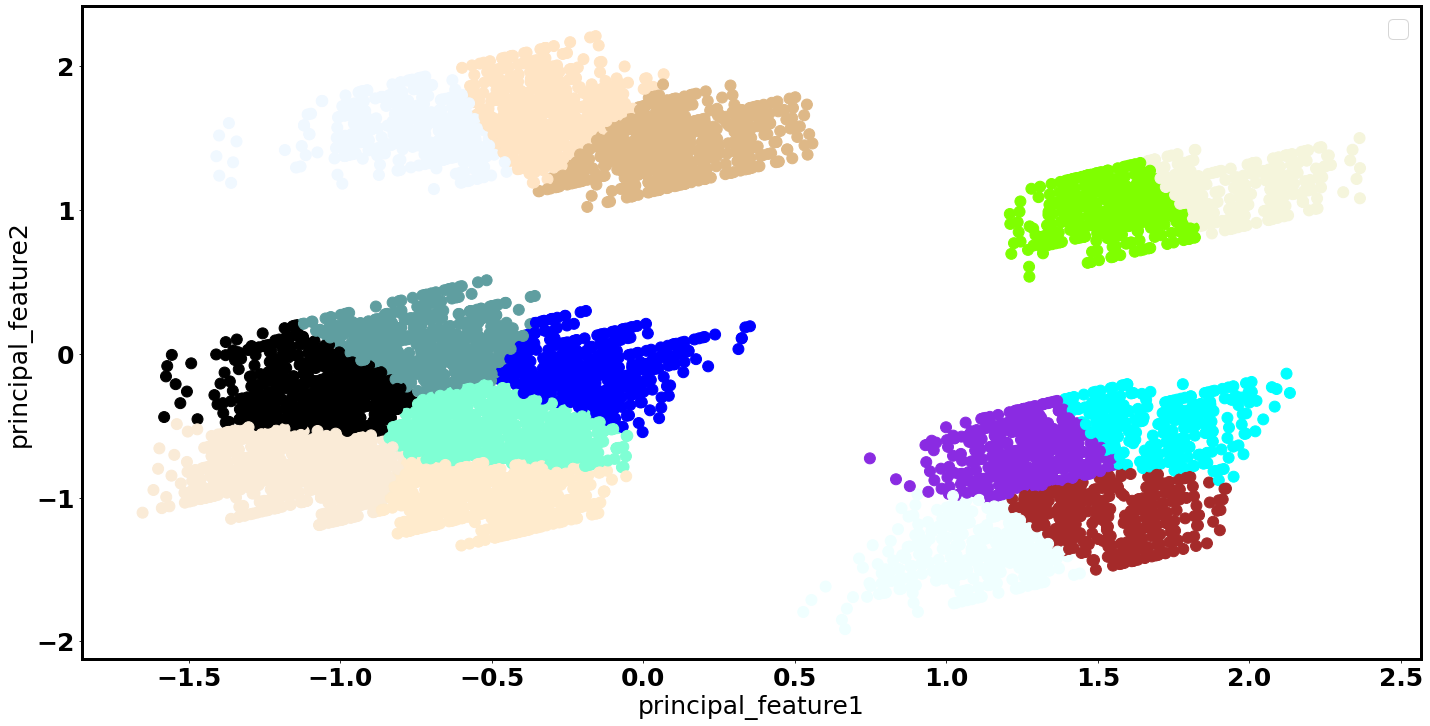

In [11]:
#plot the different clusters with the 2 main features

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

from matplotlib import colors as mcolors
fig, ax = plt.subplots()
colors = dict()
for i in range(len(list(mcolors.CSS4_COLORS.keys()))):
    colors[i]=list(mcolors.CSS4_COLORS.keys())[i]


ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]),s=120)

plt.xlabel('principal_feature1')
plt.ylabel('principal_feature2')

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

save_path = plot_path + "Original_clustered" + ".png"

fig.savefig(save_path, dpi=300)




In [12]:
### Consider the points that have the largest distance between centroid of that cluster as anomaly:
# calculate the centroid for each cluster first:

# squared distance to cluster center
centroids = kmeans[n_clusters-1].cluster_centers_
def distance(x):
    # return kmeans[x["cluster"]].transform(np.atleast_2d([x['principal_feature1'],x['principal_feature2']]))**2
    return (centroids[x["cluster"],0]-x['principal_feature1'])**2+(centroids[x["cluster"],1]-x['principal_feature2'])**2
df["D"]=df.apply(lambda x : distance(x),axis=1)

In [13]:
# Here "D" is the distance for each row to the centroids of each group
# Let's choose 2% data as anomaly ones

#!!! different kind of masks

mask = df["D"]>np.nanpercentile(df["D"],100-anomaly_ratio)
threshold = np.nanpercentile(df["D"],100-anomaly_ratio)
#number_of_outliers=int(len(df["D"])*anomaly_ratio/100)
#threshold = df["D"].nlargest(number_of_outliers).min()

# save:
df['anomaly_kmean'] = 0
df['anomaly_kmean'][mask]=1




/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


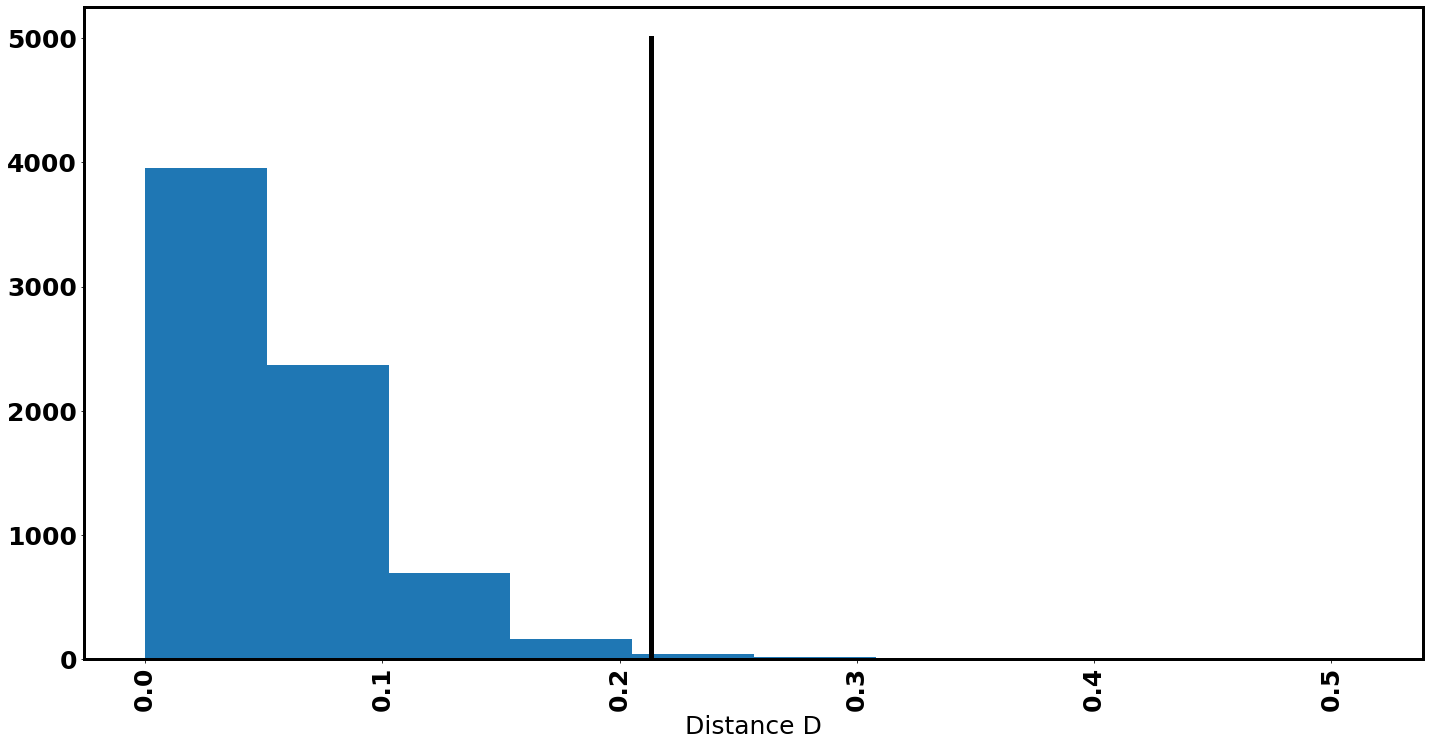

In [14]:


from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


# plot the data using Celcius
#df.plot(x='timestamp', y='value')

plt.hist(df["D"])

plt.plot([threshold,threshold],[0,5000],"k",linewidth=5)


plt.xlabel("Distance D")

plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
#plt.legend()

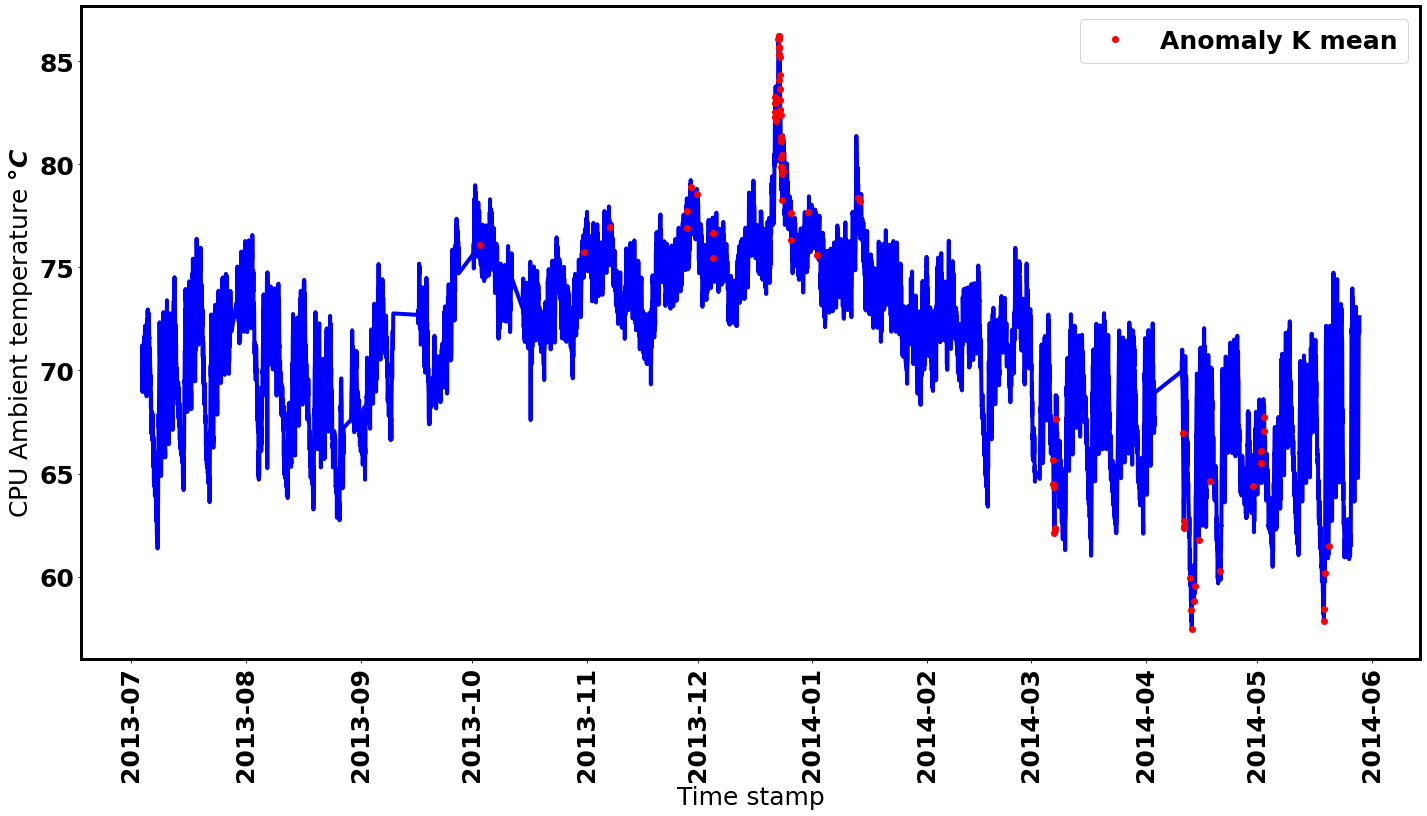

In [15]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

mask = df['anomaly_kmean'] == 1

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(df[mask]['timestamp'],df[mask]['value'],"ro",linewidth=4,label="Anomaly K mean")

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()


save_path = plot_path + "K_mean" + ".png"

fig.savefig(save_path, dpi=300)

# Isolation forest
https://en.wikipedia.org/wiki/Isolation_forest

In [197]:
## Some hyper-parameters:

outliers_fraction=0.01




In [198]:
# Similar to the K mean
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# train Iforest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly_iforest'] = pd.Series(model.predict(data))
df['anomaly_iforest'] = df['anomaly_iforest'].map( {1: 0, -1: 1} )
print(df['anomaly_iforest'].value_counts())

/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    7195
1      72
Name: anomaly_iforest, dtype: int64


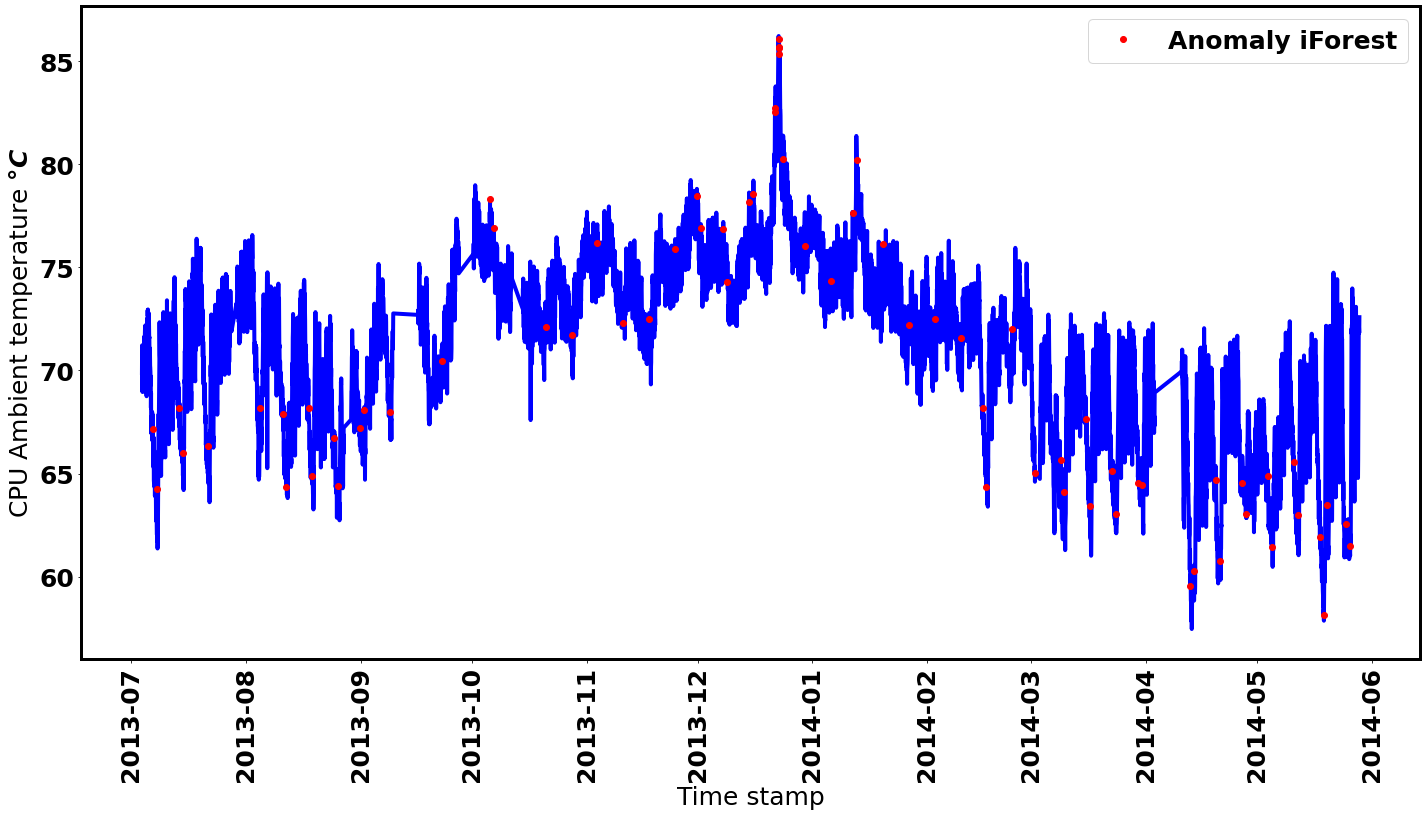

In [199]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


mask = df['anomaly_iforest']==1

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(df[mask]['timestamp'],df[mask]['value'],"ro",linewidth=4,label="Anomaly iForest")

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

save_path = plot_path + "iForest" + ".png"

fig.savefig(save_path, dpi=300)

# Let's do SVM:

In [19]:
# Hyper parameters:
outliers_fraction=0.01

In [20]:
# Same thing
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# SVM
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly_SVM'] = pd.Series(model.predict(data))
df['anomaly_SVM'] = df['anomaly_SVM'].map( {1: 0, -1: 1} )
print(df['anomaly_SVM'].value_counts())

0    7198
1      69
Name: anomaly_SVM, dtype: int64


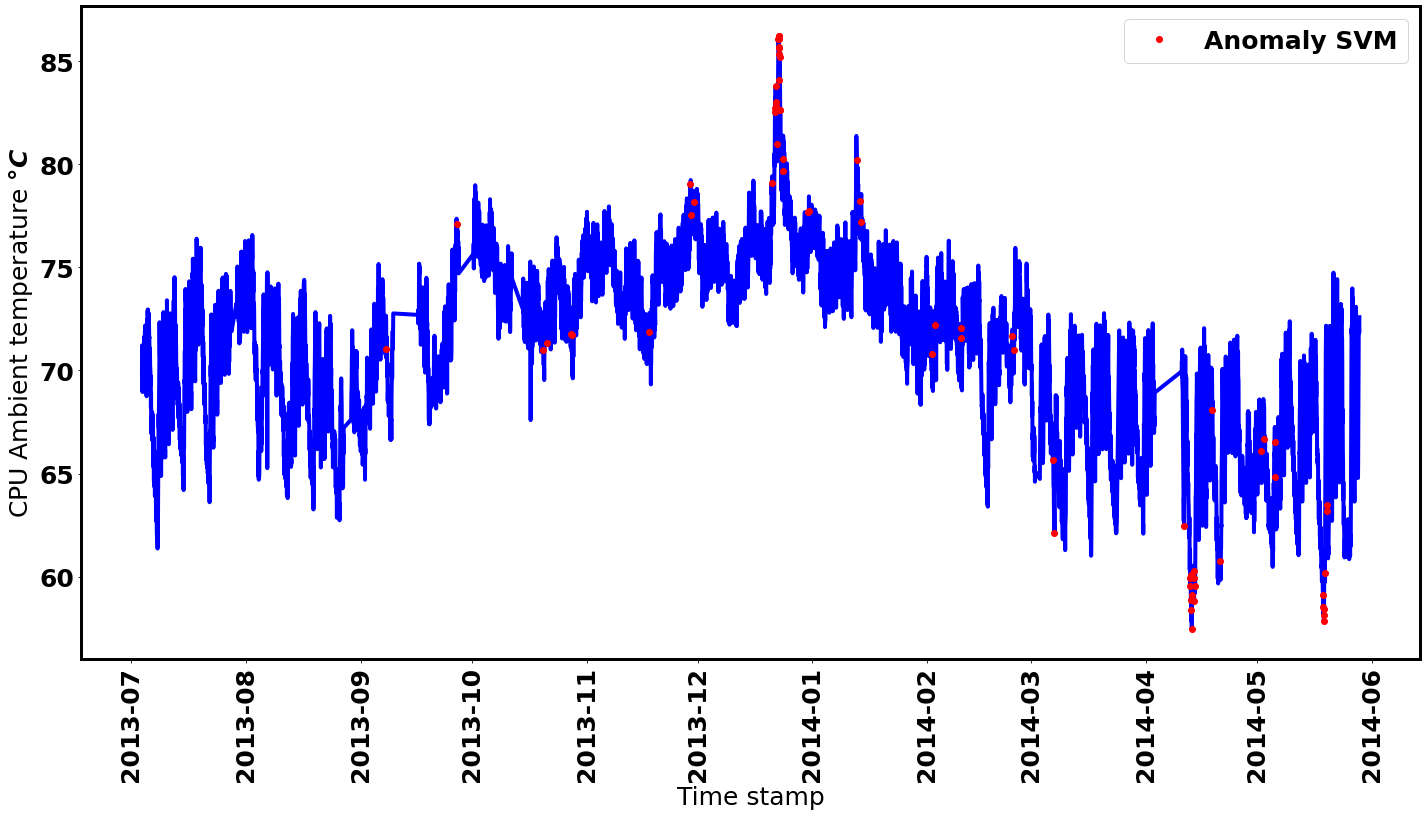

In [21]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


mask = df['anomaly_SVM']==1

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(df[mask]['timestamp'],df[mask]['value'],"ro",linewidth=4,label="Anomaly SVM")

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

save_path = plot_path + "SVM" + ".png"

fig.savefig(save_path, dpi=300)

# Naive Bayes:
naive model

In [92]:
#Hyperparameters:
outliers_fraction=0.01


In [93]:
a = df.loc[df['categories'] == 0, ['timestamp','value']]
b = df.loc[df['categories'] == 1, ['timestamp','value']]
c = df.loc[df['categories'] == 2, ['timestamp','value']]
d = df.loc[df['categories'] == 3, ['timestamp','value']]

mask = (a['value']>np.nanpercentile(a['value'],100-100*outliers_fraction)) | (a['value']<np.nanpercentile(a['value'],100*outliers_fraction))
a = a[mask]

mask = (b['value']>np.nanpercentile(b['value'],100-100*outliers_fraction)) | (b['value']<np.nanpercentile(b['value'],100*outliers_fraction))
b = b[mask]

mask = (c['value']>np.nanpercentile(c['value'],100-100*outliers_fraction)) | (c['value']<np.nanpercentile(c['value'],100*outliers_fraction))
c = c[mask]

mask = (d['value']>np.nanpercentile(d['value'],100-100*outliers_fraction)) | (d['value']<np.nanpercentile(d['value'],100*outliers_fraction))
d = d[mask]

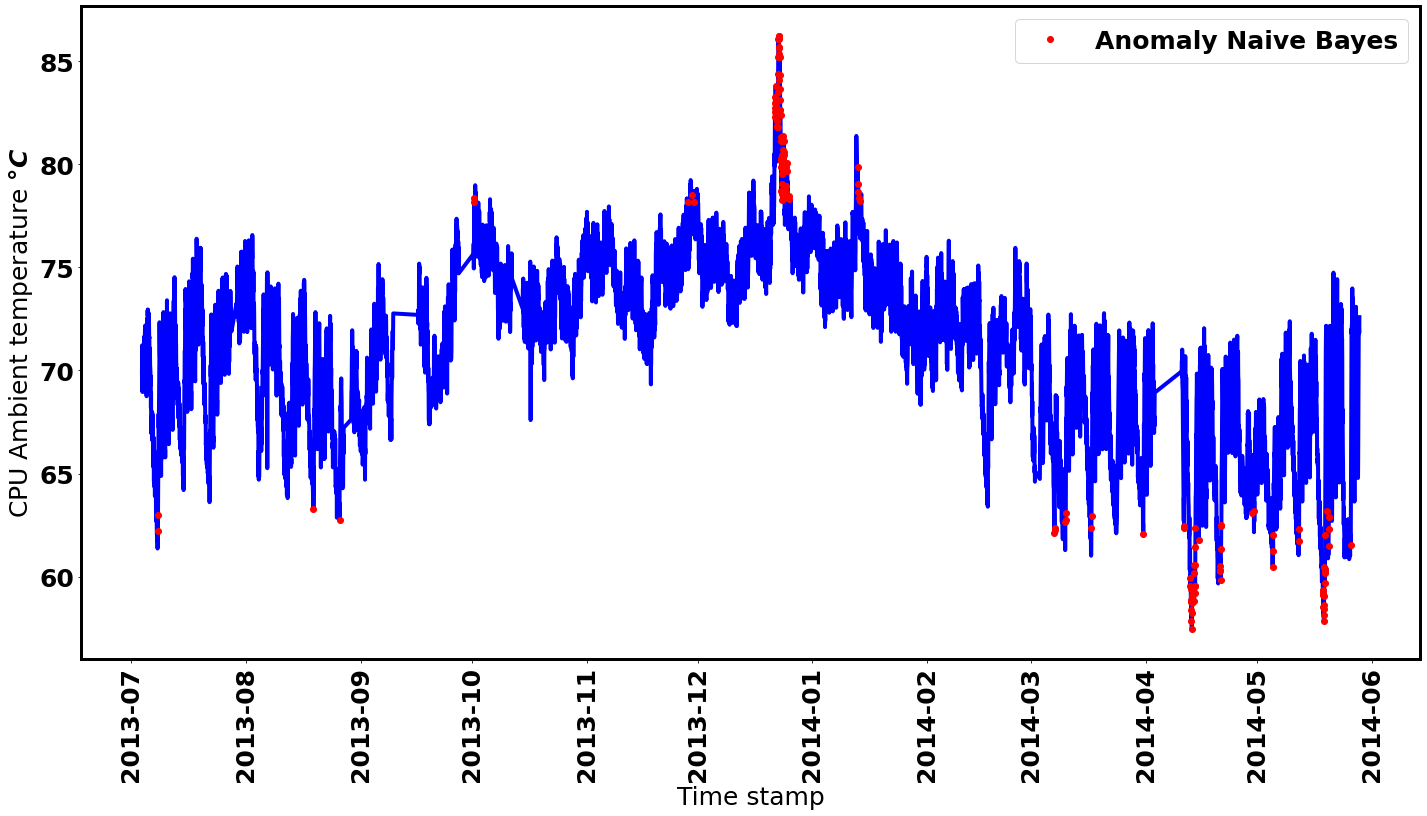

In [94]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(a['timestamp'],a['value'],"ro",linewidth=4,label="Anomaly Naive Bayes")
plt.plot(b['timestamp'],b['value'],"ro",linewidth=4)
plt.plot(c['timestamp'],c['value'],"ro",linewidth=4)
plt.plot(d['timestamp'],d['value'],"ro",linewidth=4)

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

save_path = plot_path + "Naive_Bayes" + ".png"

fig.savefig(save_path, dpi=300)

# Seems outliers_fraction=0.03 is best for iForest
Performance similar to Bayesian Changepoint

In [238]:
## Let's run Isolation forest for all data
import warnings
warnings.filterwarnings('ignore')

def isolation_forest(path,outliers_fraction=None):
    outliers_fraction=0.03
    
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hours'] = df['timestamp'].dt.hour
    df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
    # the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
    df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
    df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)


    # time with int to plot easily
    df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

    # creation of 4 distinct categories that seem useful (week end/day week & night/day)
    df['categories'] = df['WeekDay']*2 + df['daylight']
    data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
    min_max_scaler = preprocessing.StandardScaler()

    # min-max scaler
    np_scaled = min_max_scaler.fit_transform(data)

    data = pd.DataFrame(np_scaled)

    # train Iforest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    # add the data to the main  
    df['anomaly_iforest'] = pd.Series(model.predict(data))
    df['anomaly_iforest'] = df['anomaly_iforest'].map( {1: 0, -1: 1} )
    df["anomaly_score"]=-model.score_samples(data)
    return df
    
    
count=0
for p in path_all:
    
    temp = p.split("/")
    temp_name = "alpha_"+temp[-1]
    
    print("Doing %d of %d : %s"%(count,len(path_all),temp[-1]))
    
    try:
        read_path = os.path.join("results","alpha",temp[1],temp_name)
        temp_name = "alpha_"+temp[-1]
        save_path = os.path.join("results","alpha",temp[1],temp_name)
        ans = isolation_forest(path=p)

        read_data = pd.read_csv(read_path)
        read_data["anomaly_score"] = ans["anomaly_score"]
        read_data["label"] = df['anomaly_iforest']
        read_data.to_csv(save_path)
        # copy to path
        
    except:
        print("%s fails"%temp[-1])
    count+=1
    
    

Doing 0 of 58 : art_daily_no_noise.csv
Doing 1 of 58 : art_daily_perfect_square_wave.csv
Doing 2 of 58 : art_daily_small_noise.csv
Doing 3 of 58 : art_flatline.csv
Doing 4 of 58 : art_noisy.csv
Doing 5 of 58 : art_daily_flatmiddle.csv
Doing 6 of 58 : art_daily_jumpsdown.csv
Doing 7 of 58 : art_daily_jumpsup.csv
Doing 8 of 58 : art_daily_nojump.csv
Doing 9 of 58 : art_increase_spike_density.csv
Doing 10 of 58 : art_load_balancer_spikes.csv
Doing 11 of 58 : exchange-2_cpc_results.csv
Doing 12 of 58 : exchange-2_cpm_results.csv
Doing 13 of 58 : exchange-3_cpc_results.csv
Doing 14 of 58 : exchange-3_cpm_results.csv
Doing 15 of 58 : exchange-4_cpc_results.csv
Doing 16 of 58 : exchange-4_cpm_results.csv
Doing 17 of 58 : ec2_cpu_utilization_24ae8d.csv
Doing 18 of 58 : ec2_cpu_utilization_53ea38.csv
Doing 19 of 58 : ec2_cpu_utilization_5f5533.csv
Doing 20 of 58 : ec2_cpu_utilization_77c1ca.csv
Doing 21 of 58 : ec2_cpu_utilization_825cc2.csv
Doing 22 of 58 : ec2_cpu_utilization_ac20cd.csv
Doing

In [239]:
print("All set!")

All set!


In [240]:
# remove original files
for p in path_all:
    
    temp = p.split("/")
    temp_name = "random_"+temp[-1]

    read_path = os.path.join("results","alpha",temp[1],temp_name)
    os.system("rm %s"%read_path)
        